# BDT

This Jupyter Notebook contains the BDT used for separating the muon neutrino and muon anti-neutrino in the mixed sample containing $\nu_{\mu} + \bar{\nu}_{\mu}$. 

Input taking the .hdr5 files containing the Pandas dataframes for the selected sample.

### Input, importing the selected sample stored into .hdr5 file

In [1]:
#====================#
#  Import Packages   #
#====================#

import math 
import numpy as np
import awkward as ak
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import gridspec

import uproot3 as uproot

# BDT
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc, recall_score, precision_score, average_precision_score, precision_recall_curve
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from sklearn.utils.class_weight import compute_sample_weight
import joblib
import xgboost as xgb
from matplotlib.pylab import rcParams

/Users/wwang/anaconda3/envs/general/lib/python3.11/site-packages/awkward0/__init__.py:8: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if distutils.version.LooseVersion(numpy.__version__) < distutils.version.LooseVersion("1.13.1"):


In [2]:
#=====================================================================#
#  Import dataframes containing sample of mostly mixed numu anti-numu #
#=====================================================================#


df_mc = pd.read_hdf('dfs/df_run1_mc_mixed_numu_numubar.hdf5')
df_beam_on = pd.read_hdf('dfs/df_run1_data_mixed_numu_numubar.hdf5')
df_dirt = pd.read_hdf('dfs/df_run1_dirt_mixed_numu_numubar.hdf5')
df_ext = pd.read_hdf('dfs/df_run1_ext_mixed_numu_numubar.hdf5')

In [3]:
#==================================#
# Auxiliary functions used for BDT #
#==================================#


def label_signal(df_):
    # this function labels the sample, =1 for signal (nuebarCC events), and =0 for background (otherwise) # flip definition
      
    condition_numubar = (df_['truth_nuPdg']==-14)
    condition_numu = (df_['truth_nuPdg']==14)
    condition_cc = (df_['truth_isCC']==1)
    
    query_numubarcc = condition_numubar & condition_cc
    query_numucc = condition_numu & condition_cc
    
    df_["bdt_numubarcc_label"] = df_.apply(lambda row:1 if query_numubarcc[row.name] else 0, axis=1)
    df_["bdt_numucc_label"] = df_.apply(lambda row:1 if query_numucc[row.name] else 0, axis=1)
    
    #Calculate the percentage of 1's
    percentage_signal_numu = (df_["bdt_numucc_label"].sum() / len(df_)) * 100
    print(f"Labelled dataset. Portion of signal numuCC events in this sample: {percentage_signal_numu:.2f}%")
    
    percentage_signal_numubar = (df_["bdt_numubarcc_label"].sum() / len(df_)) * 100
    print(f"Labelled dataset. Portion of signal numubarCC events in this sample: {percentage_signal_numubar:.2f}%")
    
def remove_background_events(df_):
    # remove any event that is not nueCC/nuebarCC
    query = "(truth_nuPdg==14 | truth_nuPdg==-14) & truth_isCC==1"
    num_events_before = len(df_)
    df_.query(query, inplace=True) # keep only events where query=True
    contaminant_contribution = (num_events_before - len(df_))/num_events_before
    print(f"Removed {num_events_before - len(df_)} contaminants from the selection sample. This"
          f" constitutes {contaminant_contribution:.2%} of your sample. If this is large, consider refining the"
          f" initial selection process.")

### BDT Training

In [4]:
# Rename dataframe, allowing df_bdt to be other things in the future
df_bdt = df_mc

# Label the sample provided, include "bdt_nuebarcc_label" and "bdt_nuecc_label"
label_signal(df_bdt)

# Remove remaining background (everything different than nueCC/nuebarCC)
remove_background_events(df_bdt)

# Calculate extra variables
#calc_vertex_dist(df_bdt)
#calc_costheta(df_bdt)

# ============================

#chosen_var = 'bdt_nuebarcc_label' nuebarcc=signal, nuecc=background
chosen_var = 'bdt_numucc_label' # nuecc=signal, nuebarcc=background

# ============================

# List of variables used for training
training_variables = ['showervtx_diff','gap_energy','gap_flag_single_shower','gap_flag','reco_showerKE', 'cos_theta']

# Split the dataset into training and validation sets - using random_state as handle on the randomness of data
features = df_bdt[training_variables]
targets = df_bdt[chosen_var]

# Compute sample weights to balance the class distribution
sample_weights = compute_sample_weight(class_weight="balanced", y=targets)
features_train, features_test, targets_train, targets_test, sample_weights_train, sample_weights_test = train_test_split(features, targets, sample_weights, test_size=0.1, random_state=0)

# Calculate the scale by which to increase the gradient for minority class examples
#scale = minority_gradient_scaler(df_bdt.copy())
scale = 1
print('Scaling minority class events by factor = %.2e' % scale)

# Create an XGBoost classifier (we should play with these parameters)
clf = xgb.XGBClassifier(n_estimators=400, # 500
                        eta=0.05, # 0.05
                        max_depth=30, # 30
                        learning_rate=0.01,
                        scale_pos_weight=1, 
                        eval_metric=["error","auc", "logloss"],
                        objective = 'binary:logistic',
                        use_label_encoder=False # removes warning
                       )

# Train the classifier on our newly constructed dataset
eval_set = [(features_train, targets_train), (features_test, targets_test)]
clf.fit(features_train, targets_train, sample_weight=sample_weights_train, eval_set=eval_set)

# ============================

# Calculate bdt score
df_bdt.loc[:,chosen_var] = clf.predict_proba(df_bdt[training_variables])[:,1]


Labelled dataset. Portion of signal numuCC events in this sample: 73.83%
Labelled dataset. Portion of signal numubarCC events in this sample: 17.00%
Removed 2545 contaminants from the selection sample. This constitutes 9.17% of your sample. If this is large, consider refining the initial selection process.
Scaling minority class events by factor = 1.00e+00
[0]	validation_0-error:0.22247	validation_0-auc:0.81724	validation_0-logloss:0.68969	validation_1-error:0.30571	validation_1-auc:0.61659	validation_1-logloss:0.69070


/Users/wwang/anaconda3/envs/general/lib/python3.11/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/wwang/anaconda3/envs/general/lib/python3.11/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
/Users/wwang/anaconda3/envs/general/lib/python3.11/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
/Users/wwang/anaconda3/envs/general/lib/python3.11/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, Categoric

[1]	validation_0-error:0.24909	validation_0-auc:0.81987	validation_0-logloss:0.68717	validation_1-error:0.34298	validation_1-auc:0.61607	validation_1-logloss:0.68919
[2]	validation_0-error:0.26327	validation_0-auc:0.82028	validation_0-logloss:0.68470	validation_1-error:0.35170	validation_1-auc:0.61581	validation_1-logloss:0.68772
[3]	validation_0-error:0.26477	validation_0-auc:0.82057	validation_0-logloss:0.68228	validation_1-error:0.35329	validation_1-auc:0.61568	validation_1-logloss:0.68632
[4]	validation_0-error:0.26517	validation_0-auc:0.82143	validation_0-logloss:0.67988	validation_1-error:0.35646	validation_1-auc:0.61686	validation_1-logloss:0.68487
[5]	validation_0-error:0.26927	validation_0-auc:0.82246	validation_0-logloss:0.67752	validation_1-error:0.36241	validation_1-auc:0.61771	validation_1-logloss:0.68345
[6]	validation_0-error:0.27336	validation_0-auc:0.82262	validation_0-logloss:0.67520	validation_1-error:0.36281	validation_1-auc:0.61809	validation_1-logloss:0.68209
[7]	

/Users/wwang/anaconda3/envs/general/lib/python3.11/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/wwang/anaconda3/envs/general/lib/python3.11/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
/Users/wwang/anaconda3/envs/general/lib/python3.11/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
/Users/wwang/anaconda3/envs/general/lib/python3.11/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, Categoric

### Printing out the decision tree

In [5]:
lock4 = False
if lock4==True: 
    rcParams['figure.figsize'] = (100,100)
    xgb.plot_tree(clf)
    plt.show()

### Printing out relevant evaluation metric

In [6]:
# Get the relevant information for printing

results = clf.evals_result()
epochs = len(results['validation_0']['error'])
x_axis = np.linspace(0, epochs, 400, endpoint=True)

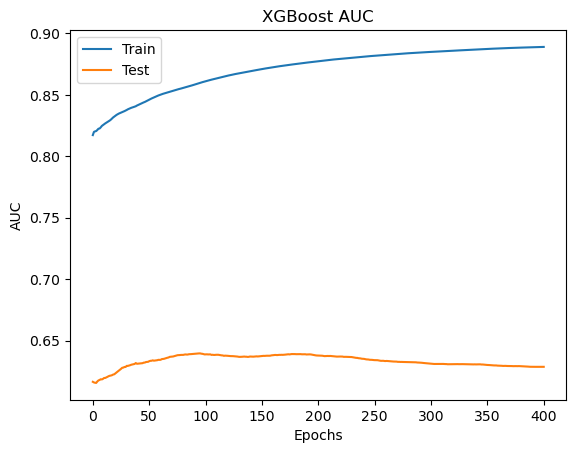

In [7]:
plt.plot(x_axis, results['validation_0']['auc'], label='Train')
plt.plot(x_axis, results['validation_1']['auc'], label='Test')
plt.legend()
plt.ylabel('AUC')
plt.xlabel('Epochs')
plt.title('XGBoost AUC')
plt.show()

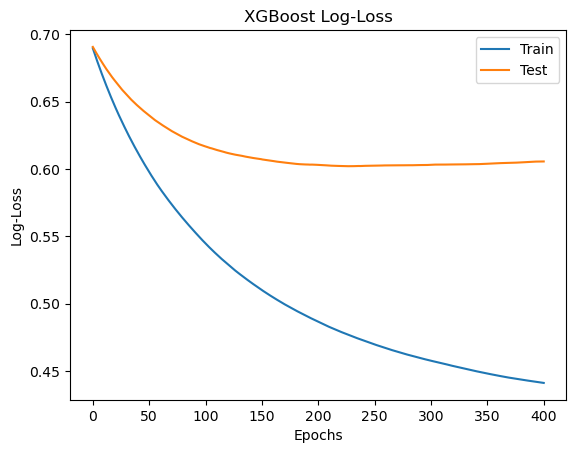

In [8]:
plt.plot(x_axis, results['validation_0']['logloss'], label='Train')
plt.plot(x_axis, results['validation_1']['logloss'], label='Test')
plt.legend()
plt.ylabel('Log-Loss')
plt.xlabel('Epochs')
plt.title('XGBoost Log-Loss')
plt.show()

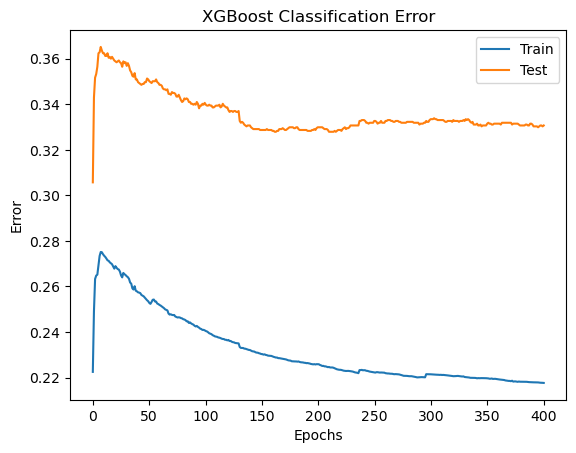

In [9]:
plt.plot(x_axis, results['validation_0']['error'], label='Train')
plt.plot(x_axis, results['validation_1']['error'], label='Test')
plt.legend()
plt.ylabel('Error')
plt.xlabel('Epochs')
plt.title('XGBoost Classification Error')
plt.show()

In [10]:
from sklearn import metrics
def buildROC(target_test, test_preds, target_train, train_preds):
    fpr_test, tpr_test, _ = metrics.roc_curve(target_test, test_preds)
    fpr_train, tpr_train, _ = metrics.roc_curve(target_train, train_preds)
    roc_auc_test = metrics.auc(fpr_test, tpr_test)
    roc_auc_train = metrics.auc(fpr_train, tpr_train)
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr_test, tpr_test, label = 'Test - AUC = %0.2f' % roc_auc_test, color='g')
    plt.plot(fpr_train, tpr_train, label = 'Train - AUC = %0.2f' % roc_auc_train, color='b')
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')

In [11]:
y_pred_proba_train = clf.predict_proba(features_train)
y_pred_proba_test = clf.predict_proba(features_test)

/Users/wwang/anaconda3/envs/general/lib/python3.11/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/wwang/anaconda3/envs/general/lib/python3.11/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
/Users/wwang/anaconda3/envs/general/lib/python3.11/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
/Users/wwang/anaconda3/envs/general/lib/python3.11/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, Categoric

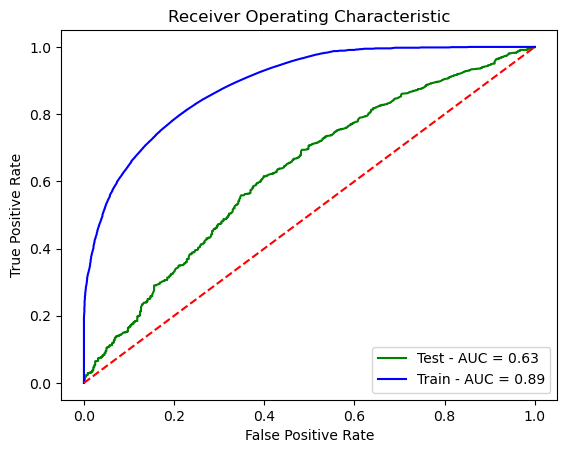

In [12]:
buildROC(targets_test, y_pred_proba_test[:, 1], targets_train, y_pred_proba_train[:, 1])